In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
# !git pull

In [3]:
import tensorflow as tf
import malaya_speech
import malaya_speech.train
from malaya_speech.train.model import fastspeech2
import numpy as np






The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





In [4]:
_pad = 'pad'
_start = 'start'
_eos = 'eos'
_punctuation = "!'(),.:;? "
_special = '-'
_letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'

MALAYA_SPEECH_SYMBOLS = (
    [_pad, _start, _eos] + list(_special) + list(_punctuation) + list(_letters)
)
rejected = "!'(),.:;?"

In [5]:
input_ids = tf.placeholder(tf.int32, [None, None])
lens = tf.placeholder(tf.int32, [None, None])
mel_outputs = tf.placeholder(tf.float32, [None, None, 80])
mel_lengths = tf.placeholder(tf.int32, [None])
energies = tf.placeholder(tf.float32, [None, None])
energies_lengths = tf.placeholder(tf.int32, [None])
f0s = tf.placeholder(tf.float32, [None, None])
f0s_lengths = tf.placeholder(tf.int32, [None])

In [6]:
config = malaya_speech.config.fastspeech2_config_v2
config = fastspeech2.Config(
    vocab_size = len(MALAYA_SPEECH_SYMBOLS), **config
)
model = fastspeech2.Model(config)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [7]:
r_training = model(input_ids, lens, f0s, energies, training = False)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
speed_ratios = tf.placeholder(tf.float32, [None], name = 'speed_ratios')
f0_ratios = tf.placeholder(tf.float32, [None], name = 'f0_ratios')
energy_ratios = tf.placeholder(tf.float32, [None], name = 'energy_ratios')

r = model.inference(input_ids, speed_ratios, f0_ratios, energy_ratios)

In [9]:
r

(<tf.Tensor 'mel_before/BiasAdd:0' shape=(?, ?, 80) dtype=float32>,
 <tf.Tensor 'add_3:0' shape=(?, ?, 80) dtype=float32>,
 <tf.Tensor 'Cast:0' shape=(?, ?) dtype=int32>,
 <tf.Tensor 'mul_1:0' shape=(?, ?) dtype=float32>,
 <tf.Tensor 'mul_2:0' shape=(?, ?) dtype=float32>)

In [10]:
decoder_output = tf.identity(r[0], name = 'decoder_output')
post_mel_outputs = tf.identity(r[1], name = 'post_mel_outputs')

In [11]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [12]:
path = 'fastspeech2-female-v2'
ckpt_path = tf.train.latest_checkpoint(path)
ckpt_path

'fastspeech2-female-v2/model.ckpt-300000'

In [13]:
saver = tf.train.Saver()
saver.restore(sess, ckpt_path)

INFO:tensorflow:Restoring parameters from fastspeech2-female-v2/model.ckpt-300000


In [14]:
import re
from unidecode import unidecode
import malaya

# Regular expression matching text enclosed in curly braces:
_curly_re = re.compile(r"(.*?)\{(.+?)\}(.*)")

normalizer = malaya.normalize.normalizer(date = False, time = False)
pad_to = 8

def tts_encode(string: str, add_eos: bool = True):
    r = [MALAYA_SPEECH_SYMBOLS.index(c) for c in string if c in MALAYA_SPEECH_SYMBOLS]
    if add_eos:
        r = r + [MALAYA_SPEECH_SYMBOLS.index('eos')]
    return r

def put_spacing_num(string):
    string = re.sub('[A-Za-z]+', lambda ele: ' ' + ele[0] + ' ', string)
    return re.sub(r'[ ]+', ' ', string).strip()

def convert_to_ascii(string):
    return unidecode(string)

def collapse_whitespace(string):
    return re.sub(_whitespace_re, ' ', string)

def cleaning(string, normalize = True, add_eos = True):
    sequence = []
    string = convert_to_ascii(string)
    string = string.replace('&', ' dan ')
    if normalize:
        string = normalizer.normalize(string, 
                                      check_english = False, 
                                      normalize_entity = False, 
                                      normalize_text = False,
                                      normalize_url = True,
                                      normalize_email = True)
        string = string['normalize']
    else:
        string = string
    string = string.lower()
    string = put_spacing_num(string)
    string = ''.join([c for c in string if c not in rejected])
    string = re.sub(r'[ ]+', ' ', string).strip()
    ids = tts_encode(string, add_eos = add_eos)
    text_input = np.array(ids)
    num_pad = pad_to - ((len(text_input) + 2) % pad_to)
    text_input = np.pad(
        text_input, ((1, 1)), 'constant', constant_values = ((1, 2))
    )
    text_input = np.pad(
        text_input, ((0, num_pad)), 'constant', constant_values = 0
    )
    
    return string, text_input

In [15]:
import matplotlib.pyplot as plt

In [25]:
# https://umno-online.my/2020/12/28/isu-kartel-daging-haram-lagi-pihak-gesa-kerajaan-ambil-tindakan-tegas-drastik/

t, ids = cleaning('Masa aku kat KL, ada main mintak rasuah. Aku cakap kat agensi kerajaan tu. Dia cuma kata tak payah bagi. Tak ambik nama pun. mungkin itu la kot selemah lemah iman, tolak dalam hati tapi tak mampu buat tindakan.', add_eos = False)
t, ids

('masa aku kat kuala lumpur ada main mintak rasuah aku cakap kat agensi kerajaan tu dia cuma kata tak payah bagi tidak ambik nama pun mungkin itu la kot selemah lemah iman tolak dalam hati tapi tak mampu buat tindakan',
 array([ 1, 52, 40, 58, 40, 13, 40, 50, 60, 13, 50, 40, 59, 13, 50, 60, 40,
        51, 40, 13, 51, 60, 52, 55, 60, 57, 13, 40, 43, 40, 13, 52, 40, 48,
        53, 13, 52, 48, 53, 59, 40, 50, 13, 57, 40, 58, 60, 40, 47, 13, 40,
        50, 60, 13, 42, 40, 50, 40, 55, 13, 50, 40, 59, 13, 40, 46, 44, 53,
        58, 48, 13, 50, 44, 57, 40, 49, 40, 40, 53, 13, 59, 60, 13, 43, 48,
        40, 13, 42, 60, 52, 40, 13, 50, 40, 59, 40, 13, 59, 40, 50, 13, 55,
        40, 64, 40, 47, 13, 41, 40, 46, 48, 13, 59, 48, 43, 40, 50, 13, 40,
        52, 41, 48, 50, 13, 53, 40, 52, 40, 13, 55, 60, 53, 13, 52, 60, 53,
        46, 50, 48, 53, 13, 48, 59, 60, 13, 51, 40, 13, 50, 54, 59, 13, 58,
        44, 51, 44, 52, 40, 47, 13, 51, 44, 52, 40, 47, 13, 48, 52, 40, 53,
        13, 59, 54, 

In [26]:
%%time

o = sess.run([decoder_output, post_mel_outputs], 
             feed_dict = {input_ids: [ids], 
                          speed_ratios: [1.0],
                          f0_ratios: [1.0], 
                          energy_ratios: [1.0]})

CPU times: user 1.54 s, sys: 142 ms, total: 1.68 s
Wall time: 81.9 ms


In [27]:
o[1].shape

(1, 1192, 80)

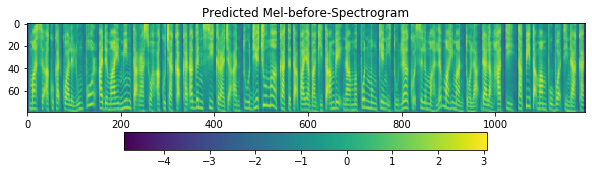

In [28]:
mel_outputs_ = np.reshape(o[1], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

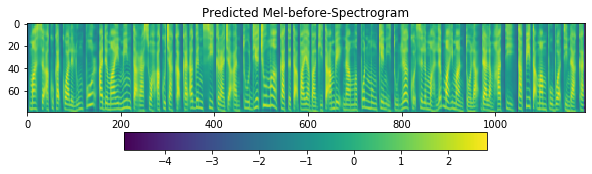

In [29]:
mel_outputs_ = np.reshape(o[0], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [21]:
import pickle

with open('a.pkl', 'wb') as fopen:
    pickle.dump([np.reshape(o[0], [-1, 80]), np.reshape(o[1], [-1, 80])], fopen)

In [22]:
saver = tf.train.Saver()
saver.save(sess, 'fastspeech2-female-v2-output/model.ckpt')

'fastspeech2-female-v2-output/model.ckpt'

In [30]:
strings = ','.join(
    [
        n.name
        for n in tf.get_default_graph().as_graph_def().node
        if ('Variable' in n.op
        or 'gather' in n.op.lower()
        or 'Placeholder' in n.name
        or 'ratios' in n.name
        or 'post_mel_outputs' in n.name
        or 'decoder_output' in n.name
        or 'alignment_histories' in n.name)
        and 'adam' not in n.name
        and 'global_step' not in n.name
        and 'Assign' not in n.name
        and 'ReadVariableOp' not in n.name
        and 'Gather' not in n.name
        and 'IsVariableInitialized' not in n.name
    ]
)
strings.split(',')

['Placeholder',
 'Placeholder_1',
 'Placeholder_2',
 'Placeholder_3',
 'Placeholder_4',
 'Placeholder_5',
 'Placeholder_6',
 'Placeholder_7',
 'weight',
 'model/embeddings/position_embeddings/Placeholder',
 'model/decoder/position_embeddings/Placeholder',
 'speed_ratios',
 'f0_ratios',
 'energy_ratios',
 'decoder_output',
 'post_mel_outputs']

In [31]:
def freeze_graph(model_dir, output_node_names):

    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            'directory: %s' % model_dir
        )

    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path

    absolute_model_dir = '/'.join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + '/frozen_model.pb'
    clear_devices = True
    with tf.Session(graph = tf.Graph()) as sess:
        saver = tf.train.import_meta_graph(
            input_checkpoint + '.meta', clear_devices = clear_devices
        )
        saver.restore(sess, input_checkpoint)
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess,
            tf.get_default_graph().as_graph_def(),
            output_node_names.split(','),
        )
        with tf.gfile.GFile(output_graph, 'wb') as f:
            f.write(output_graph_def.SerializeToString())
        print('%d ops in the final graph.' % len(output_graph_def.node))

In [32]:
freeze_graph('fastspeech2-female-v2-output', strings)

INFO:tensorflow:Restoring parameters from fastspeech2-female-v2-output/model.ckpt
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 155 variables.
INFO:tensorflow:Converted 155 variables to const ops.
2394 ops in the final graph.


In [33]:
def load_graph(frozen_graph_filename):
    with tf.gfile.GFile(frozen_graph_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
                
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def)
        
    return graph

In [34]:
g = load_graph('fastspeech2-female-v2-output/frozen_model.pb')

In [35]:
test_sess = tf.InteractiveSession(graph = g)

In [36]:
X = g.get_tensor_by_name('import/Placeholder:0')
speed_ratios = g.get_tensor_by_name('import/speed_ratios:0')
f0_ratios = g.get_tensor_by_name('import/f0_ratios:0')
energy_ratios = g.get_tensor_by_name('import/energy_ratios:0')

In [37]:
output_nodes = ['decoder_output', 'post_mel_outputs']
outputs = {n: g.get_tensor_by_name(f'import/{n}:0') for n in output_nodes}

In [38]:
%%time

o = test_sess.run(outputs, feed_dict = {X: [ids], 
                             speed_ratios: [1.0],
                             f0_ratios: [1.0], 
                             energy_ratios: [1.0]})

CPU times: user 1.77 s, sys: 131 ms, total: 1.9 s
Wall time: 441 ms


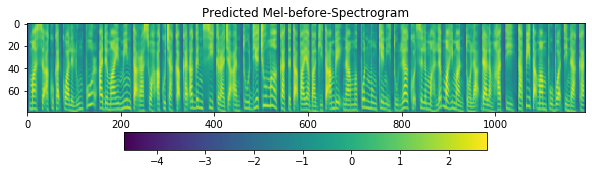

In [39]:
mel_outputs_ = np.reshape(o['decoder_output'], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

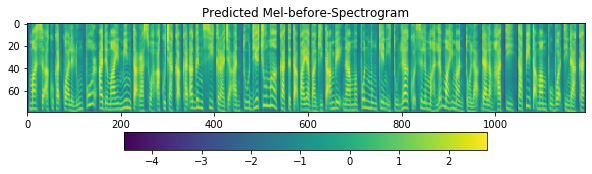

In [40]:
mel_outputs_ = np.reshape(o['post_mel_outputs'], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [41]:
from tensorflow.tools.graph_transforms import TransformGraph

In [42]:
transforms = ['add_default_attributes',
             'remove_nodes(op=Identity, op=CheckNumerics)',
             'fold_batch_norms',
             'fold_old_batch_norms',
             'quantize_weights(fallback_min=-1024, fallback_max=1024)',
             'strip_unused_nodes',
             'sort_by_execution_order']

In [43]:
pb = 'fastspeech2-female-v2-output/frozen_model.pb'

In [44]:
input_graph_def = tf.GraphDef()
with tf.gfile.FastGFile(pb, 'rb') as f:
    input_graph_def.ParseFromString(f.read())

transformed_graph_def = TransformGraph(input_graph_def, 
                                           ['Placeholder', 'speed_ratios', 'f0_ratios', 'energy_ratios'],
                                           output_nodes, transforms)
    
with tf.gfile.GFile(f'{pb}.quantized', 'wb') as f:
    f.write(transformed_graph_def.SerializeToString())

Instructions for updating:
Use tf.gfile.GFile.


In [45]:
g = load_graph('fastspeech2-female-v2-output/frozen_model.pb.quantized')

In [46]:
test_sess = tf.InteractiveSession(graph = g)
X = g.get_tensor_by_name(f'import/Placeholder:0')
speed_ratios = g.get_tensor_by_name('import/speed_ratios:0')
f0_ratios = g.get_tensor_by_name('import/f0_ratios:0')
energy_ratios = g.get_tensor_by_name('import/energy_ratios:0')
outputs = {n: g.get_tensor_by_name(f'import/{n}:0') for n in output_nodes}

In [47]:
%%time

o = test_sess.run(outputs, feed_dict = {X: [ids], 
                             speed_ratios: [1.0],
                             f0_ratios: [1.0], 
                             energy_ratios: [1.0]})

CPU times: user 1.83 s, sys: 134 ms, total: 1.96 s
Wall time: 500 ms


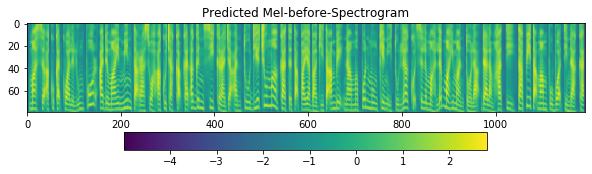

In [48]:
mel_outputs_ = np.reshape(o['decoder_output'], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

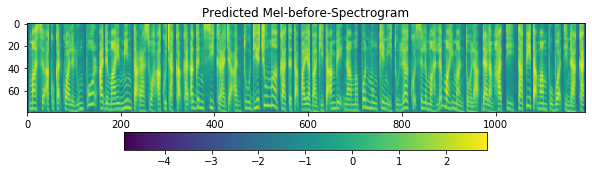

In [49]:
mel_outputs_ = np.reshape(o['post_mel_outputs'], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()